In [5]:
import numpy as np
import matplotlib.pyplot as plt
from Fourierbasis import generate_fourier_basis_function

period = 1/ (2 * np.pi)
n = 1000
alpha = 2

In [6]:
def logistic(z):
    return 1 / (1 + np.exp(-z))
    
def prior_log_density(theta, gradient = False):
    p = len(theta)
    k = np.arange(1,p+1).reshape(p,1)
    if gradient:
        # px1 array
        return - n**(1/(2*alpha + 1))* (k**(2*alpha) * theta)
    return -0.5 * n**(1/(2*alpha + 1)) * np.dot(k**(2*alpha).T,(theta**2))

def log_likelihood(theta, X, y, gradient = False):
    ff = generate_fourier_basis_function(theta)
    if gradient:
        p = len(theta)//2
        k = np.arange(1,p+1).reshape(1,p)/period
        diff = (y - logistic(ff(X))).T
        sine_block = 2**0.5 * np.sin(np.dot(X,k))
        cos_block = 2**0.5 *np.cos(np.dot(X,k))
        concat_block = np.zeros((n,2*p))
        concat_block[:,::2] = sine_block
        concat_block[:,1::2] = cos_block
        # px1 array
        return np.dot(diff[::2], concat_block).T
        
    log_like = np.dot(y.T, ff(X)) - np.log(1 + np.exp(ff(X))).sum()
    return log_like

# Gradient of log-likelihood function
def grad_log_likelihood(theta, X, y):
    grad_prior = prior_log_density(theta, True)
    grad_like = log_likelihood(theta, X, y, True)
    
    return grad_like + grad_prior

# Unadjusted Langevin algorithm
def langevin_algorithm(num_samples, step_size, initial_theta, X, y):
    theta_current = initial_theta
    samples = [theta_current]
    p = len(initial_theta)
    for i in range(num_samples):
        # Compute the gradient of the log-likelihood
        grad_ll = grad_log_likelihood(theta_current, X, y)

        # Update theta using Langevin dynamics
        theta_proposed = theta_current + step_size * grad_ll + np.sqrt(2 * step_size) * np.random.randn(p, 1)

        # Accept the proposal
        theta_current = theta_proposed
        samples.append(theta_current)

    return np.array(samples)

def gradient_descent(num_iterations, step_size, initial_theta, X, y):
    theta_current = initial_theta
    samples = [theta_current]
    p = len(initial_theta)
    for i in range(num_samples):
        grad_ll = log_likelihood(theta_current, X, y, True)

        theta_proposed = theta_current + step_size * grad_ll
        theta_current = theta_proposed
        samples.append(theta_current)
    
    return np.array(samples)

In [8]:


#  Generate synthetic data with canonical link
num_terms = 100
coefficients = np.array([1/i**3 for i in range(1,num_terms+1)]).reshape(num_terms,1)
f = generate_fourier_basis_function(coefficients)

# g^-1 = A'



# np.random.seed(42)
X = np.random.rand(n, 1)
y = (np.random.rand(n, 1) <= logistic(f(X))).astype(int)

# y = (4 + 3 * X + np.random.randn(100, 1) > 5).astype(int)


In [2]:
num_samples = 10000
step_size = 0.00001

samples = {}
samples_gd = {}

In [13]:
for i in [10,20,30]:
    initial_theta = coefficients[:i]
    # Run Langevin algorithm
    samples[i] = langevin_algorithm(num_samples, step_size, initial_theta, X, y)
    # samples_gd[i] = gradient_descent(num_samples, step_size, initial_theta, X, y)

/var/folders/ml/8p_sn9z54h5_8bx1hbprczc40000gn/T/ipykernel_47946/1205860125.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/ml/8p_sn9z54h5_8bx1hbprczc40000gn/T/ipykernel_47946/1205860125.py:9: RuntimeWarning: overflow encountered in multiply
  return - n**(1/(2*alpha + 1))* (k**(2*alpha) * theta)
/var/folders/ml/8p_sn9z54h5_8bx1hbprczc40000gn/T/ipykernel_47946/1205860125.py:46: RuntimeWarning: invalid value encountered in add
  theta_proposed = theta_current + step_size * grad_ll + np.sqrt(2 * step_size) * np.random.randn(p, 1)


In [18]:
step_size = 0.0000001
samples_new = {}
for i in [10,20,30]:
    initial_theta = coefficients[:i]
    # Run Langevin algorithm
    samples_new[i] = langevin_algorithm(num_samples, step_size, initial_theta, X, y)

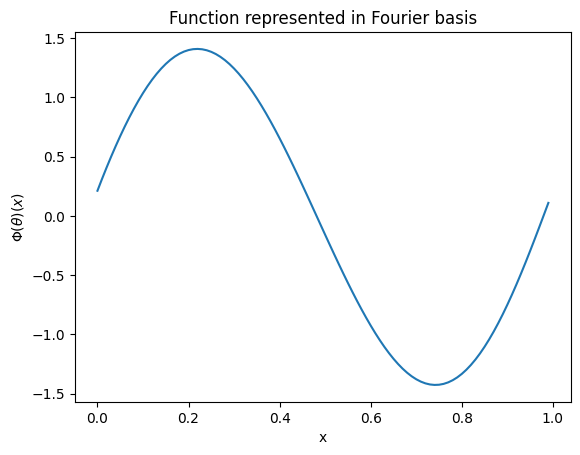

In [3]:
xx = np.arange(0, 1,0.01)
xx = xx.reshape(xx.shape[0],1)
plt.plot(xx, f(xx))
plt.xlabel('x')
plt.ylabel('$\\Phi(\\theta)(x)$')
plt.title('Function represented in Fourier basis')
plt.savefig('phi.png')
plt.show()

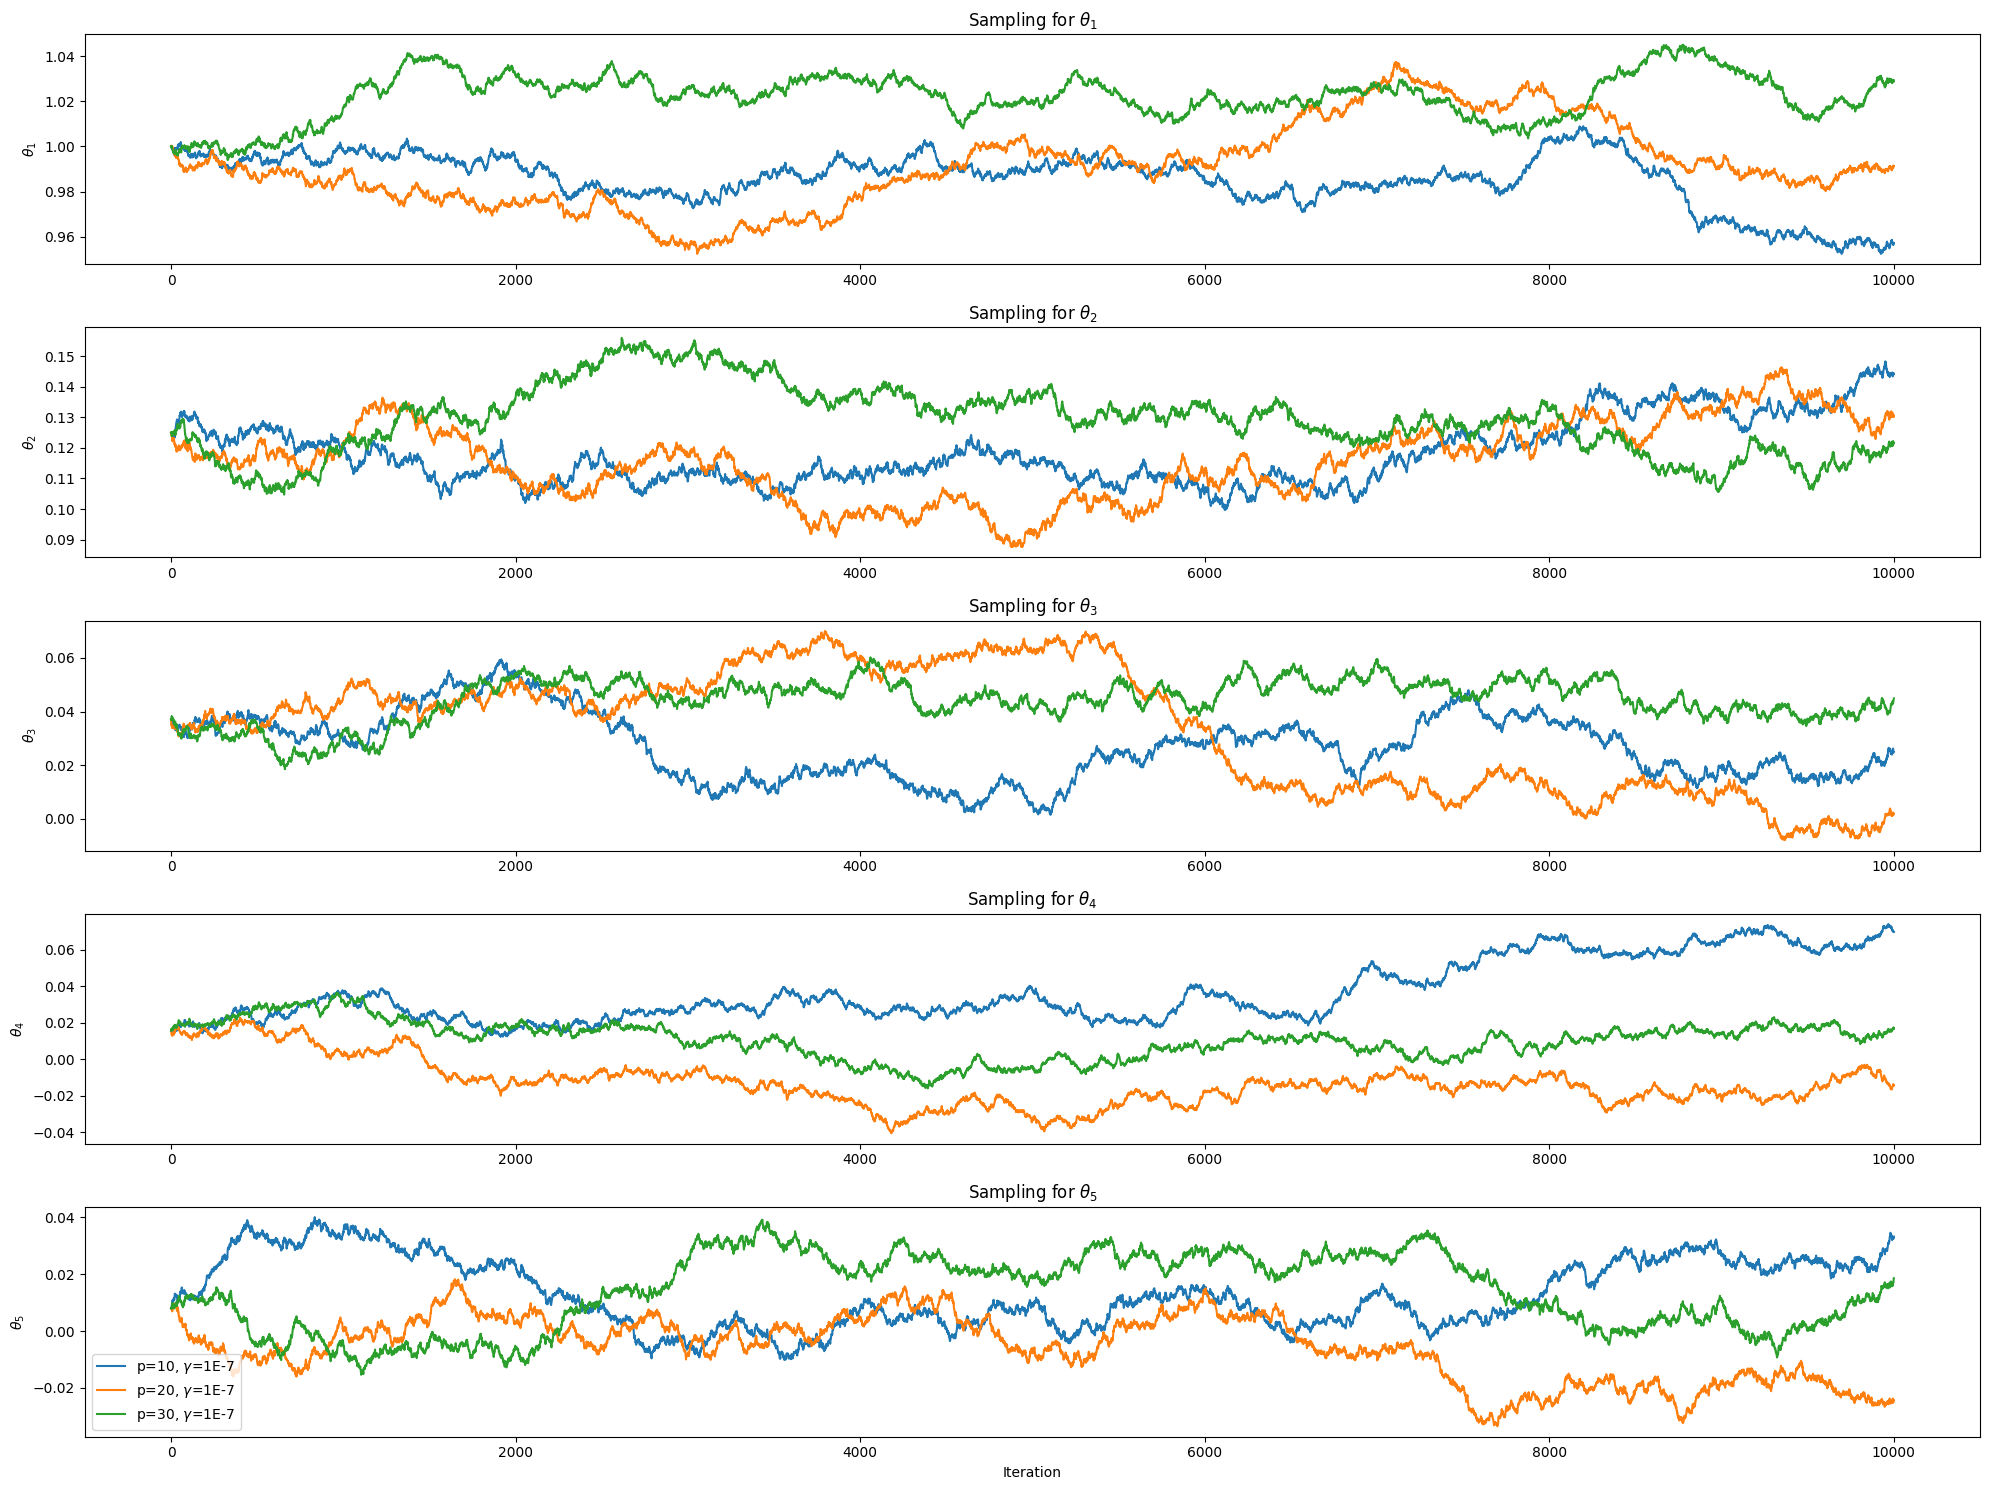

In [20]:
plt.figure(figsize=(20, 15))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(samples_new[10][:, i])
    plt.plot(samples_new[20][:, i])
    plt.plot(samples_new[30][:, i])
    
    plt.ylabel(f'$\\theta_{i+1}$')
    plt.title(f'Sampling for $\\theta_{i+1}$')
plt.xlabel('Iteration')
plt.legend(['p=10, $\\gamma$=1E-7', 'p=20, $\\gamma$=1E-7', 'p=30, $\\gamma$=1E-7'])
plt.savefig('PosteriorLangevin2.png')
plt.tight_layout()
plt.show()

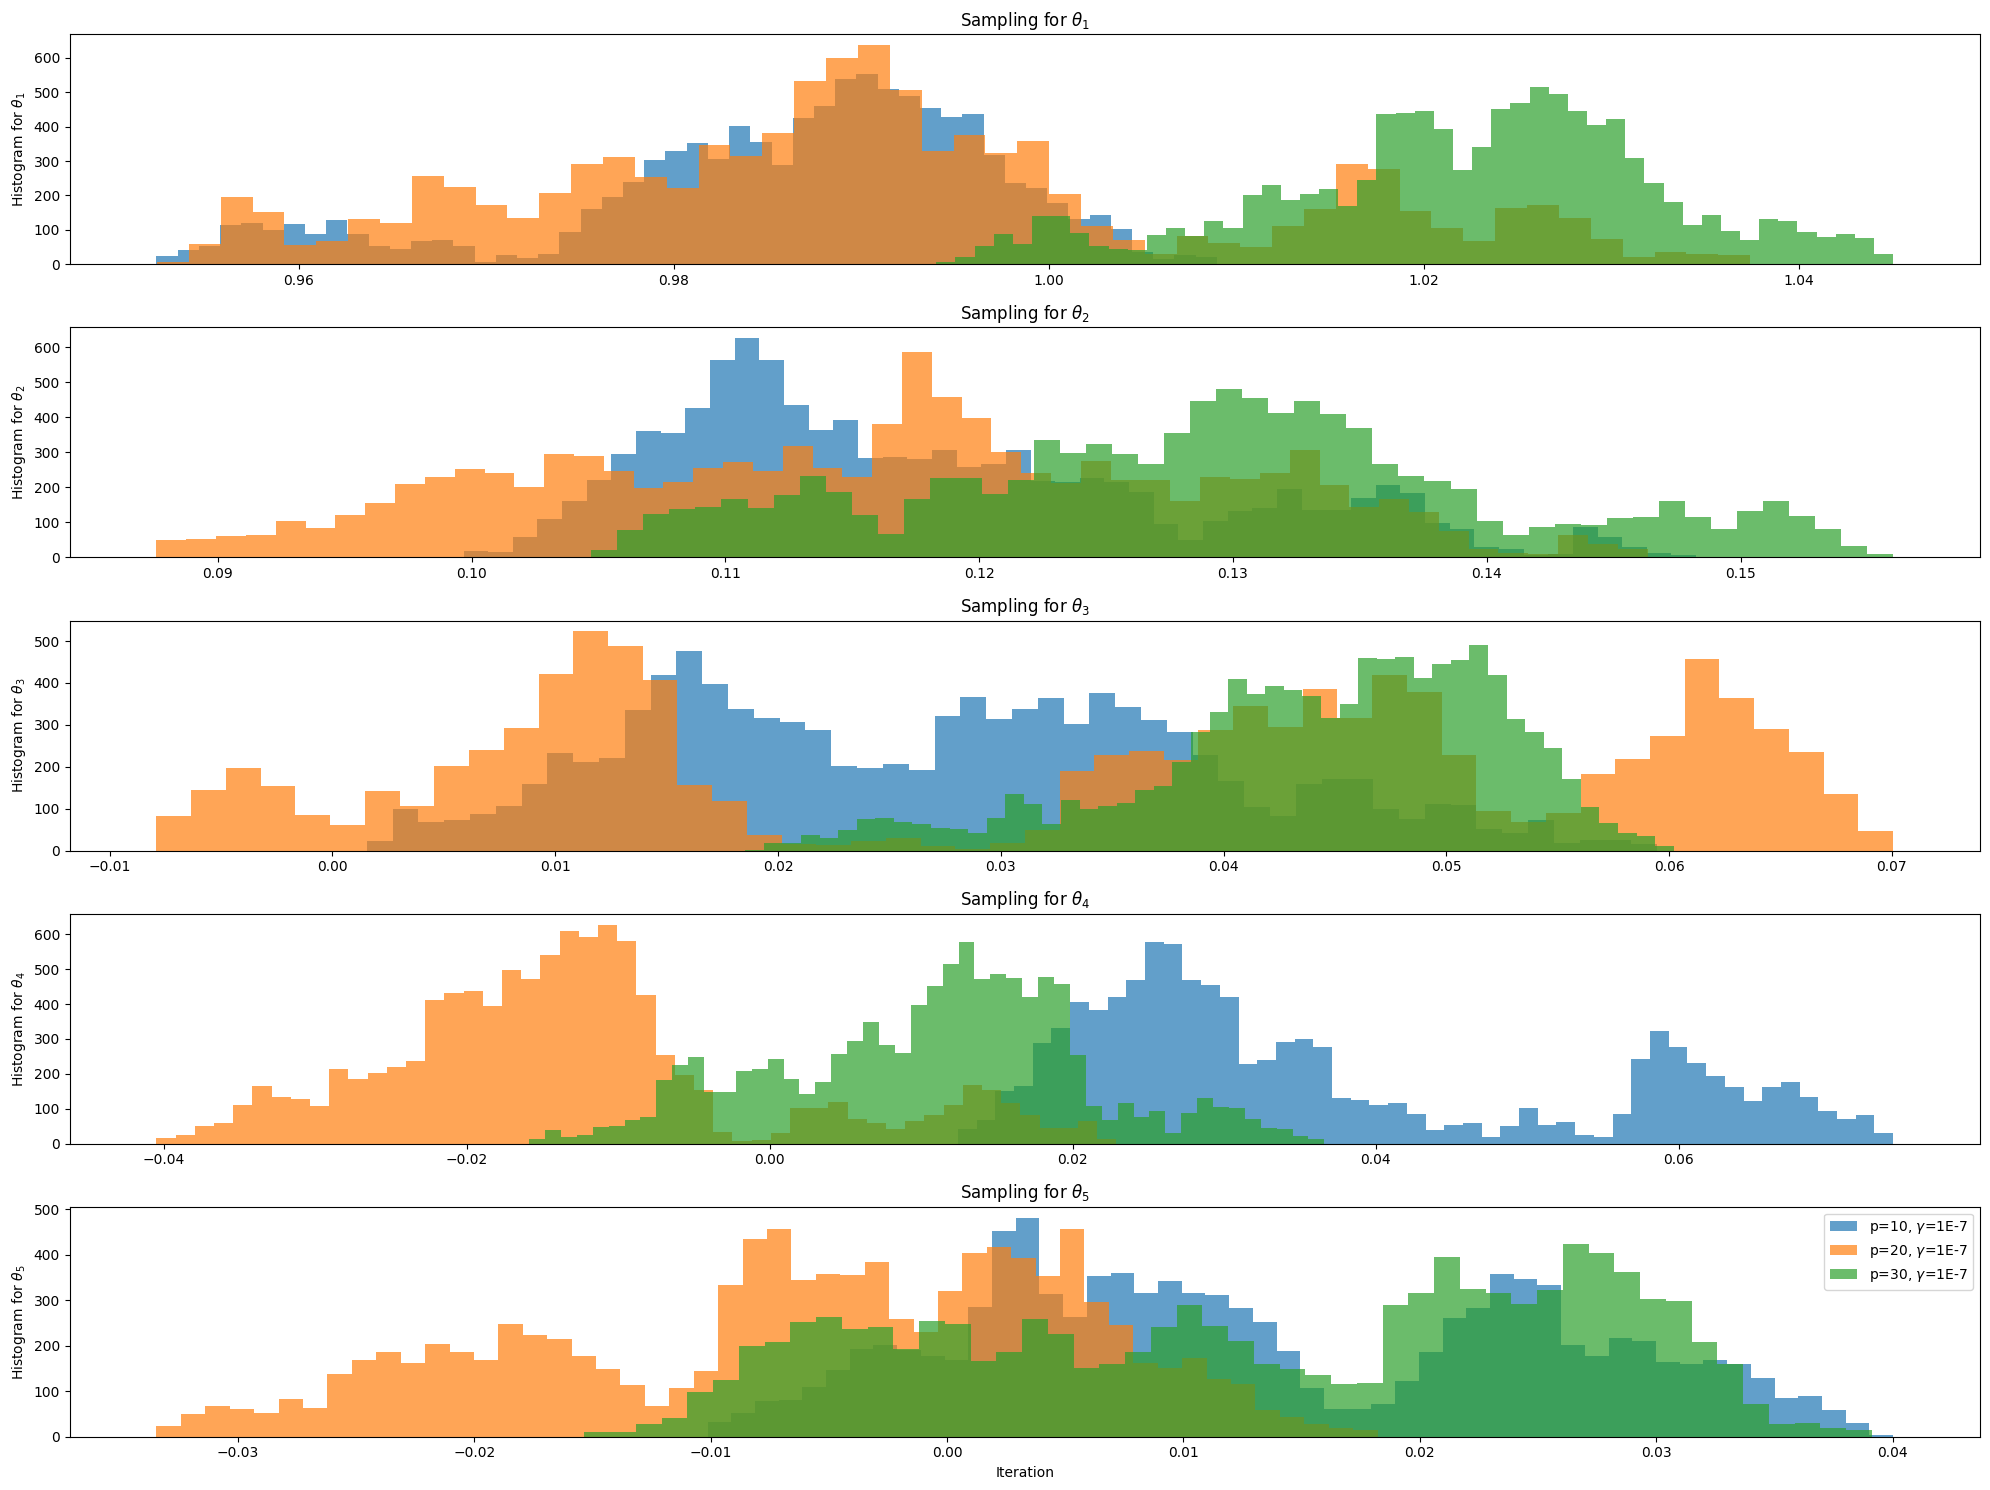

In [23]:
plt.figure(figsize=(20, 15))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.hist(samples_new[10][:, i], bins =50, alpha = 0.7)
    plt.hist(samples_new[20][:, i], bins =50, alpha = 0.7)
    plt.hist(samples_new[30][:, i], bins =50, alpha =0.7)
    
    plt.ylabel(f'Histogram for $\\theta_{i+1}$')
    plt.title(f'Sampling for $\\theta_{i+1}$')
plt.xlabel('Iteration')
plt.legend(['p=10, $\\gamma$=1E-7', 'p=20, $\\gamma$=1E-7', 'p=30, $\\gamma$=1E-7'])
plt.savefig('PosteriorLangevinHist.png')
plt.tight_layout()
plt.show()